In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from collections import Counter

In [2]:
# 1. Definim calea către directorul cu imaginile și fișierul CSV cu label-urile
data_dir = 'data'
csv_path = os.path.join(data_dir, 'labels.csv')

# 2. Dimensiunea imaginilor
img_size = 48

# 3. Dictionar pentru etichete și indexarea acestora
emotion_labels = {
    'anger': 0,
    'contempt': 1,
    'disgust': 2,
    'fear': 3,
    'happy': 4,
    'neutral': 5,
    'sad': 6,
    'surprise': 7
}

# 4. Inițializăm liste pentru stocarea imaginilor și label-urilor
X = []
y = []

# 5. Parcurgem fiecare folder de emoții
for emotion in emotion_labels.keys():
    folder_path = os.path.join(data_dir, emotion)
    
    # Verificăm dacă folderul există
    if os.path.exists(folder_path):
        # Parcurgem imaginile din folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            
            # Încărcăm și preprocesăm imaginea
            img = cv2.imread(img_path)
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Conversie la grayscale
            img_resized = cv2.resize(img_gray, (img_size, img_size))  # Redimensionare
            
            # Normalizare la valori între 0 și 1
            img_normalized = img_resized / 255.0
            
            # Adăugăm canalul de culoare (1)
            img_final = np.expand_dims(img_normalized, axis=-1)  # (48, 48, 1)
            
            # Adăugăm imaginea și label-ul corespunzător în liste
            X.append(img_final)
            y.append(emotion_labels[emotion])  # Emoția este transformată în index


In [3]:
# 6. Convertim listele în array-uri numpy
X = np.array(X, dtype='float32')
y = np.array(y)

print(f"Forma imaginilor: {X.shape}")  # (n_samples, 48, 48, 1)
print(f"Forma label-urilor: {y.shape}")  # (n_samples,)

# 7. One-hot encoding pentru label-uri
y_onehot = to_categorical(y, num_classes=len(emotion_labels))


Forma imaginilor: (29042, 48, 48, 1)
Forma label-urilor: (29042,)


In [4]:
# Împărțim datele: 70% antrenare, 15% validare, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (20329, 48, 48, 1), Validation shape: (4356, 48, 48, 1), Test shape: (4357, 48, 48, 1)


In [8]:
batch_size = 32

# 4. Augmentarea Datelor
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 5. Definirea Modelului CNN Optimizat
model = Sequential()

# Bloc 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.3))  # Dropout după primul bloc
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 2
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 3
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.4))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.6))

model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'ReLU' is not defined

In [17]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# 1. Parametri Inițiali
num_classes = len(emotion_labels)
img_size = 48
batch_size = 64
epochs = 50

# 2. Încărcarea și Preprocesarea Datelor
X = []
y = []

for emotion, label in emotion_labels.items():
    folder_path = os.path.join(data_dir, emotion)
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, (img_size, img_size))
                img_normalized = img_resized / 255.0
                img_final = np.expand_dims(img_normalized, axis=-1)

                X.append(img_final)
                y.append(label)

X = np.array(X, dtype='float32')
y = np.array(y)
y_onehot = to_categorical(y, num_classes=num_classes)

# 3. Împărțirea Datelor (70% Antrenare, 15% Validare, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42, stratify=y_onehot)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. Augmentarea Datelor (ușoară)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

# 5. Model CNN Simplu
model = Sequential()

# Bloc 1 – Mai puține filtre
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Straturi Dense
model.add(Dense(128, kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# 6. Compilarea Modelului
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 7. Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'checkpoints/best_model_simple.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 8. Antrenarea Modelului
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# 9. Evaluarea Modelului pe Setul de Test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Acuratețe pe setul de test: {test_accuracy * 100:.2f}%")

# 10. Încărcarea Modelului cu Cele Mai Bune Performanțe
from tensorflow.keras.models import load_model
best_model = load_model('checkpoints/best_model_simple.h5')
print("Cel mai bun model a fost încărcat.")


c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_35 (ReLU)                 │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_36 (ReLU)                 │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_37 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,520 (4.58 MB)

 Trainable params: 1,200,072 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
317/318 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1954 - loss: 2.5433
Epoch 1: val_accuracy improved from -inf to 0.24151, saving model to checkpoints/best_model_simple.keras
318/318 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.1955 - loss: 2.5426 - val_accuracy: 0.2415 - val_loss: 2.0928 - learning_rate: 1.0000e-04
Epoch 2/50
317/318 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2448 - loss: 2.2445
Epoch 2: val_accuracy improved from 0.24151 to 0.33586, saving model to checkpoints/best_model_simple.keras
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.2449 - loss: 2.2443 - val_accuracy: 0.3359 - val_loss: 1.8738 - learning_rate: 1.0000e-04
Epoch 3/50
317/318 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2690 - loss: 2.1392
Epoch 3: val_accuracy improved from 0.33586 to 0.36295, saving model to checkpoints/best_model_simple.keras
318/318 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.2691 - loss: 2.1389 - val_accuracy: 0.3629 - val_loss: 1.8503 - lea

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'checkpoints/best_model_simple.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [21]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 1. Configurarea Datelor
num_classes = len(emotion_labels)
img_size = 48
batch_size = 64
epochs = 100

# 2. Împărțirea Datelor
X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

model = Sequential()

# Bloc 1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)))  # input_shape=(48,48,3)
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 2
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 3
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloc 4
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(512))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Compilarea Modelului
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# 4. Callbacks pentru Antrenament
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    filepath='checkpoints/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 5. Antrenarea Modelului
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

# 6. Evaluarea Modelului pe Setul de Test
test_loss, test_accuracy = model.evaluate(X_val, y_val)
print(f"Acuratețe pe setul de test: {test_accuracy * 100:.2f}%")

# 7. Încărcarea Modelului cu Cele Mai Bune Performanțe
from tensorflow.keras.models import load_model
best_model = load_model('checkpoints/best_model.keras')
print("Cel mai bun model a fost încărcat.")


c:\Users\Andrei\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_50 (ReLU)                 │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_51 (ReLU)                 │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_52 (ReLU)                 │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_53 (ReLU)                 │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 256)      │       590,08

 Total params: 3,647,816 (13.92 MB)

 Trainable params: 3,643,464 (13.90 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.2716 - loss: 2.0586
Epoch 1: val_accuracy improved from -inf to 0.34154, saving model to checkpoints/best_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 107s 274ms/step - accuracy: 0.2719 - loss: 2.0576 - val_accuracy: 0.3415 - val_loss: 1.5600 - learning_rate: 0.0010
Epoch 2/100
363/364 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.5135 - loss: 1.2361
Epoch 2: val_accuracy improved from 0.34154 to 0.56860, saving model to checkpoints/best_model.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 100s 275ms/step - accuracy: 0.5136 - loss: 1.2359 - val_accuracy: 0.5686 - val_loss: 1.1033 - learning_rate: 0.0010
Epoch 3/100
363/364 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5923 - loss: 1.0697
Epoch 3: val_accuracy did not improve from 0.56860
364/364 ━━━━━━━━━━━━━━━━━━━━ 99s 273ms/step - accuracy: 0.5923 - loss: 1.0697 - val_accuracy: 0.5583 - val_loss: 1.0983 - learning_rate: 0.0010
Epoch 4/100
363/364 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms

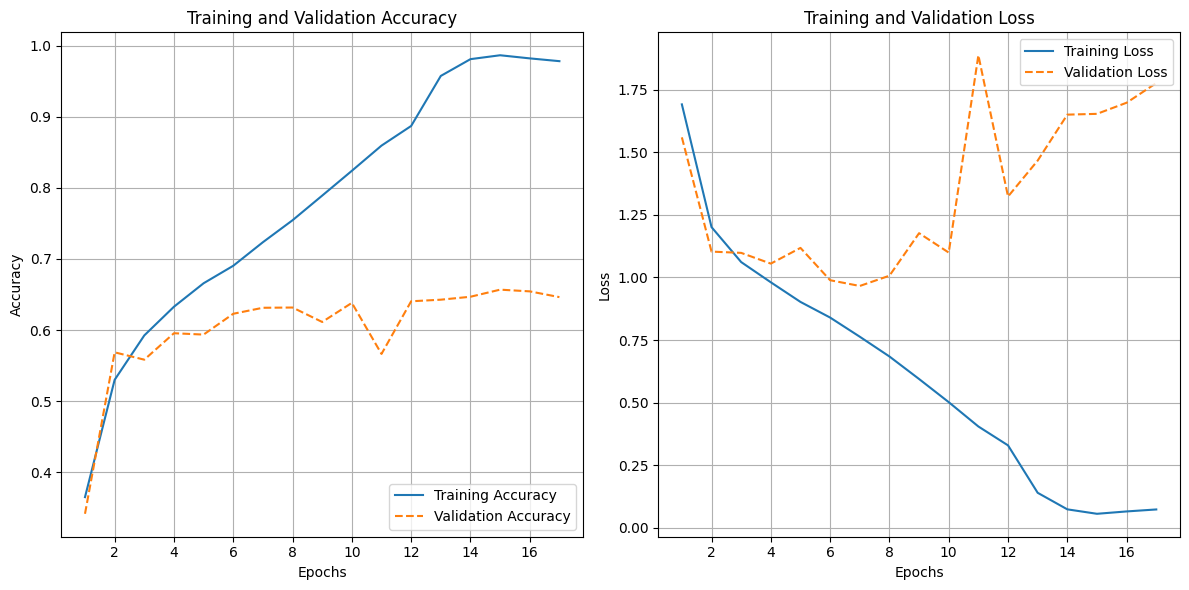

182/182 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step


<Figure size 1000x800 with 0 Axes>

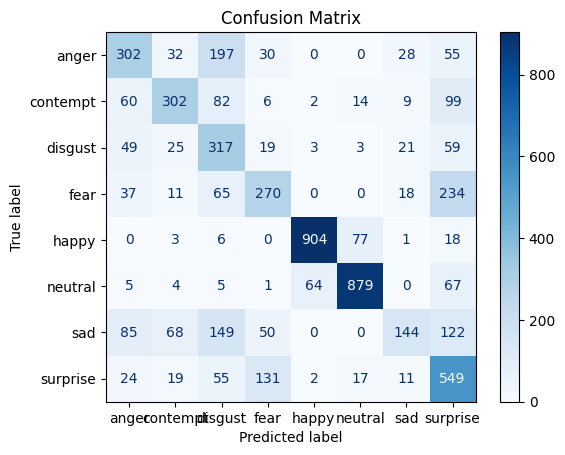

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. Accesarea istoricului de antrenament
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# 2. Plot pentru acuratețe
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, linestyle='--', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 3. Plot pentru pierdere (loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, linestyle='--', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# 4. Matricea de confuzie
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertim probabilitățile în clase
y_true = np.argmax(y_val, axis=1)  # Convertim one-hot la clase

cm = confusion_matrix(y_true, y_pred_classes)
labels = list(emotion_labels.keys())  # Etichetele claselor

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()
